Saving SI_L11_GMM_DATASET.csv to SI_L11_GMM_DATASET (23).csv


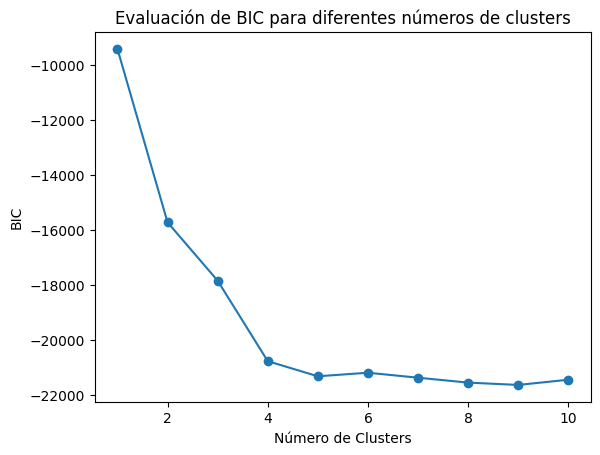

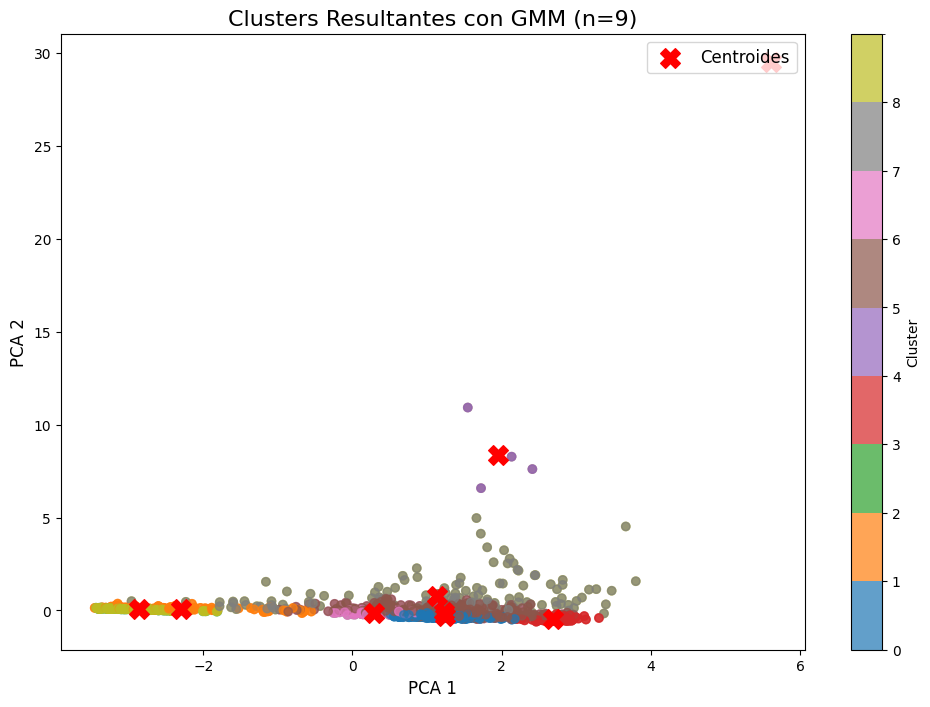

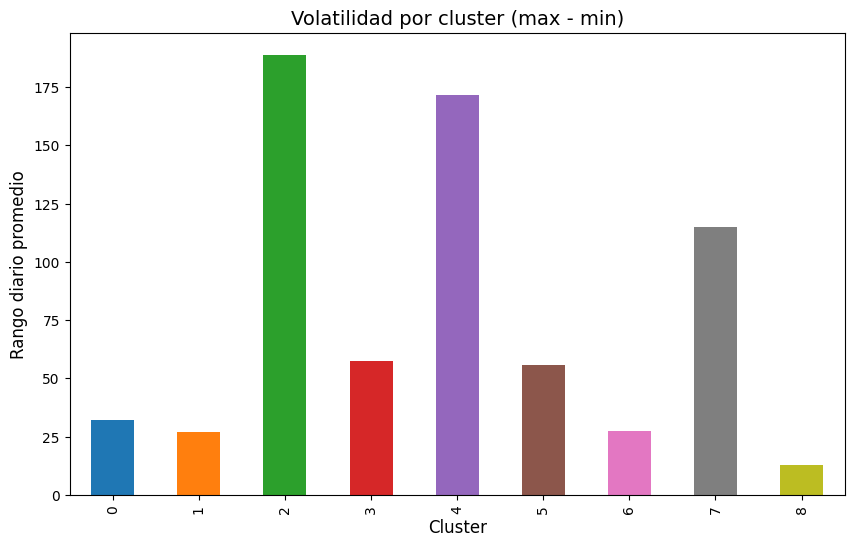

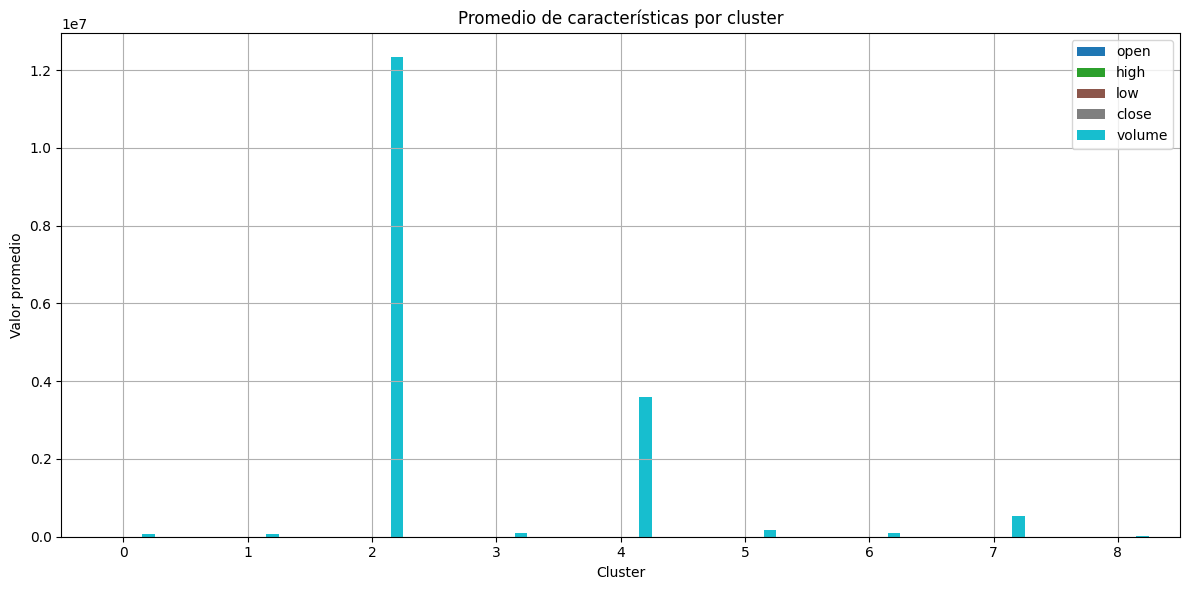

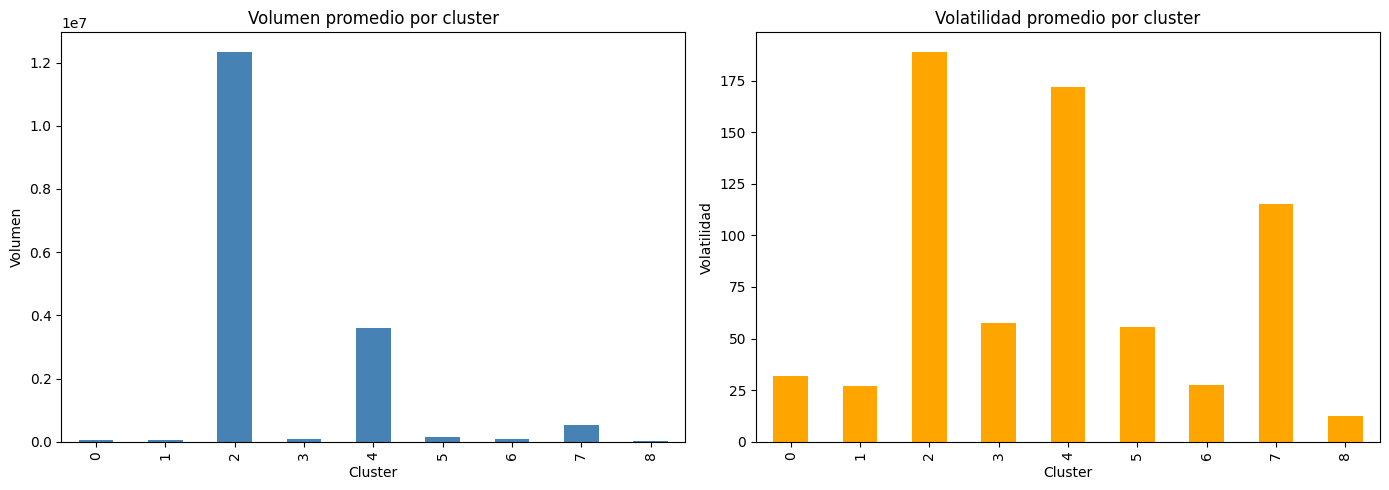

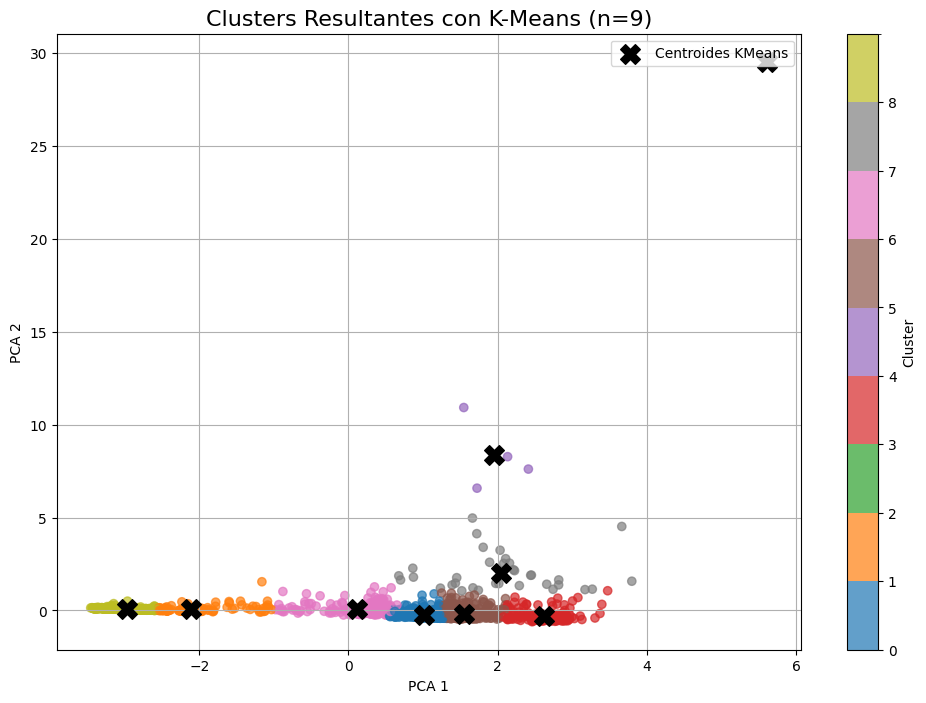

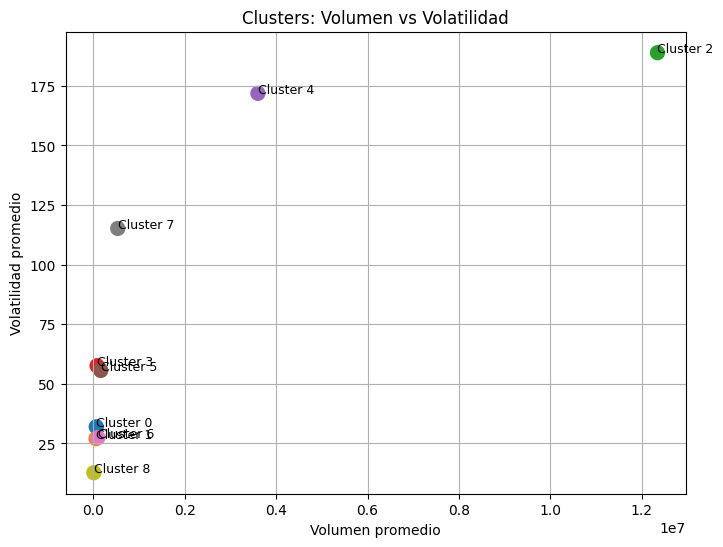

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from google.colab import files

# 1. Preprocesar los datos
uploaded = files.upload()
file_path = list(uploaded.keys())[0]
data = pd.read_csv(file_path)
features = ['open', 'high', 'low', 'close', 'volume']
data = data[features].dropna()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# 2. Aplicar GMM
gmm = GaussianMixture(n_components=9, covariance_type='full', random_state=42)
gmm.fit(data_scaled)
labels = gmm.predict(data_scaled)

# 3. Determinar número óptimo de clusters (BIC)
bic_scores = []
n_components_range = range(1, 11)
for n in n_components_range:
    gmm_tmp = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm_tmp.fit(data_scaled)
    bic_scores.append(gmm_tmp.bic(data_scaled))

plt.plot(n_components_range, bic_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('BIC')
plt.title('Evaluación de BIC para diferentes números de clusters')
plt.show()

# 4. Visualizar clusters
import matplotlib.colors as mcolors

pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_scaled)
centroids = pca.transform(gmm.means_)

plt.figure(figsize=(12, 8))
cmap = plt.colormaps['tab10']
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap=cmap, alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroides', zorder=5)
plt.title(f'Clusters Resultantes con GMM (n=9)', fontsize=16)
plt.xlabel('PCA 1', fontsize=12)
plt.ylabel('PCA 2', fontsize=12)
norm = mcolors.BoundaryNorm(boundaries=range(10), ncolors=9)
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap=cmap, norm=norm, alpha=0.7)
cbar = plt.colorbar(scatter, ticks=range(9))
cbar.set_label('Cluster')

plt.legend(loc='upper right', fontsize=12)
plt.show()

# 5. Interpretar grupos y relación con volatilidad
data['Cluster'] = labels
data['Volatilidad'] = data['high'] - data['low']
volatilidad_promedio = data.groupby('Cluster')['Volatilidad'].mean()

colors = plt.colormaps['tab10'](range(9))
plt.figure(figsize=(10, 6))
volatilidad_promedio.plot(kind='bar', color=colors)
plt.title('Volatilidad por cluster (max - min)', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Rango diario promedio', fontsize=12)
plt.show()

from sklearn.cluster import KMeans

# Pregunta 2 - Características promedio por cluster
media_por_cluster = data.groupby('Cluster')[features].mean()

# Gráfico de barras con características por cluster
media_por_cluster.plot(kind='bar', figsize=(12, 6), colormap='tab10')
plt.title('Promedio de características por cluster')
plt.ylabel('Valor promedio')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Pregunta 3 - Volatilidad y volumen por cluster (con subplots separados)
agrupado = data.groupby('Cluster')[['Volatilidad', 'volume']].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

agrupado['volume'].plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Volumen promedio por cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Volumen')

agrupado['Volatilidad'].plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Volatilidad promedio por cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Volatilidad')

plt.tight_layout()
plt.show()

# Pregunta 4 - Comparación con K-Means (con mapa de colores corregido)
kmeans = KMeans(n_clusters=9, random_state=42)
kmeans_labels = kmeans.fit_predict(data_scaled)
kmeans_centroids = pca.transform(kmeans.cluster_centers_)

cmap = plt.colormaps['tab10']
norm = mcolors.BoundaryNorm(boundaries=range(10), ncolors=9)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=kmeans_labels, cmap=cmap, norm=norm, alpha=0.7)
plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], c='black', marker='X', s=200, label='Centroides KMeans', zorder=5)
cbar = plt.colorbar(scatter, ticks=range(9))
cbar.set_label('Cluster')
plt.title('Clusters Resultantes con K-Means (n=9)', fontsize=16)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Pregunta 5 - Mapa Volumen vs Volatilidad (con colores correctos)
colors = [cmap(i) for i in agrupado.index]

plt.figure(figsize=(8, 6))
plt.scatter(agrupado['volume'], agrupado['Volatilidad'], s=100, c=colors)
for i, row in agrupado.iterrows():
    plt.text(row['volume'], row['Volatilidad'] + 0.01, f'Cluster {i}', fontsize=9)
plt.title('Clusters: Volumen vs Volatilidad')
plt.xlabel('Volumen promedio')
plt.ylabel('Volatilidad promedio')
plt.grid(True)
plt.show()

